
--- OBV - On Balance Volume for JOBY ---
Output OBV (last 5): Date
2024-04-24    166674100.0
2024-04-25    172858100.0
2024-04-26    179146900.0
2024-04-29    174743600.0
2024-04-30    171078800.0
dtype: float64


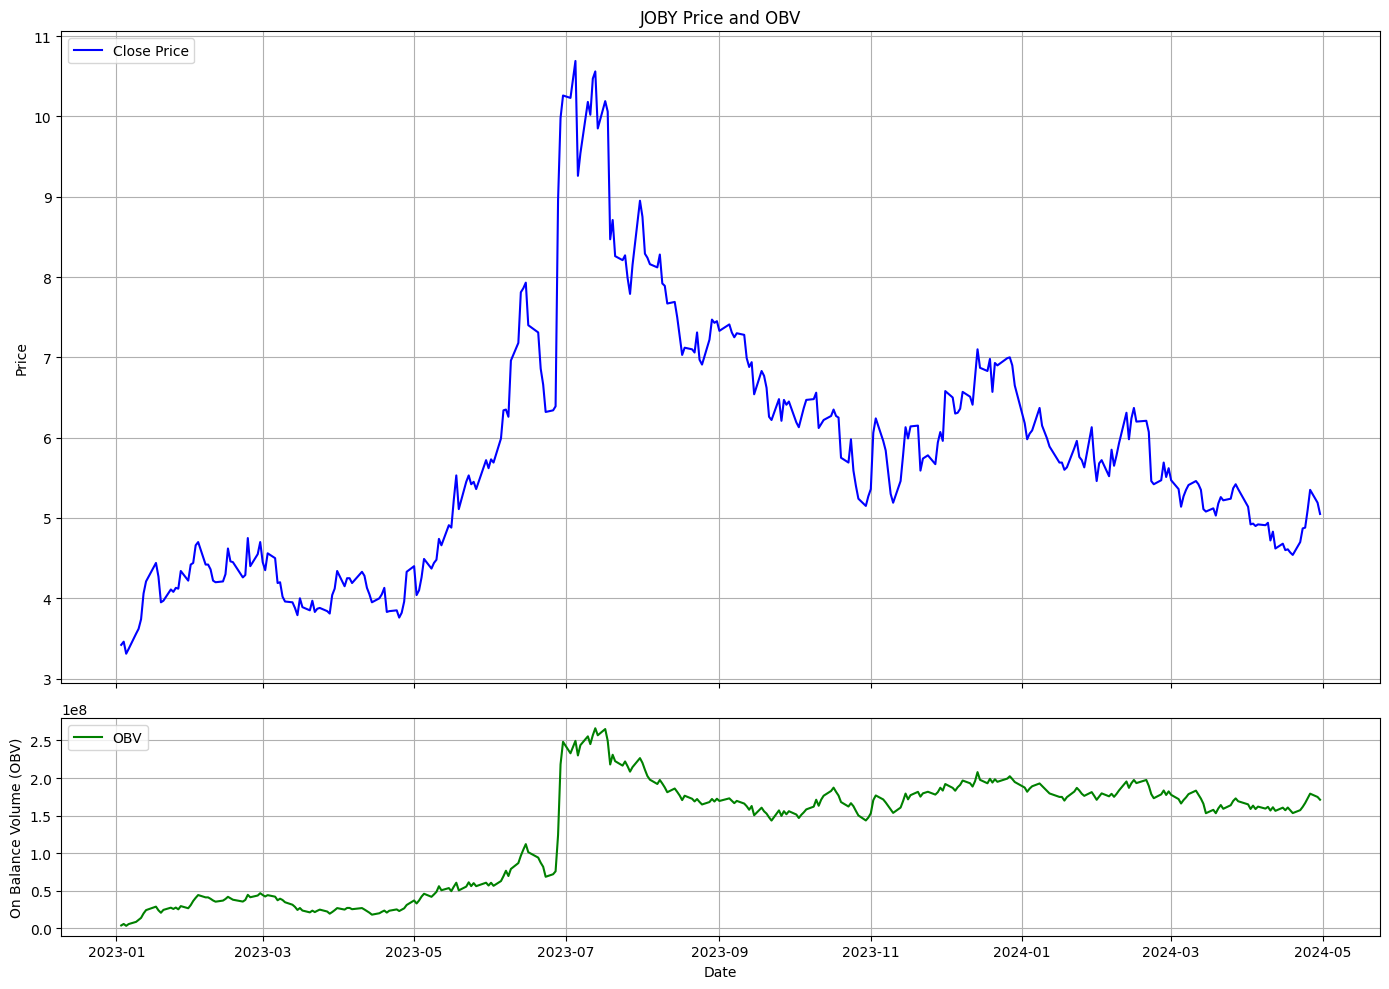

In [3]:
import yfinance as yf
import talib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Data Fetching using yfinance ---
ticker_symbol = "JOBY"  # Example: Microsoft Corp.
data = yf.download(ticker_symbol, start="2023-01-01", end="2024-05-01", auto_adjust=False, progress=False)

# Handle MultiIndex columns first
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(level=1)

# Now check for data availability
if data.empty or 'Volume' not in data.columns or data['Volume'].isnull().all():
    print(f"No data or insufficient volume data found for {ticker_symbol}. Exiting.")
else:
    close_prices = data['Close'].dropna()
    # Ensure volume corresponds to the close_prices index after dropna
    volume_data = data['Volume'].reindex_like(close_prices).dropna()
    # Ensure close_prices and volume_data have the same index after potential drops
    common_index = close_prices.index.intersection(volume_data.index)
    close_prices = close_prices.loc[common_index]
    volume_data = volume_data.loc[common_index]
    date_index = common_index


    # --- 2. OBV Calculation ---
    # OBV requires Close prices and Volume.
    # TA-Lib expects volume to be float or double. yfinance volume is typically int.
    if len(close_prices) > 1 and len(volume_data) > 1: # Needs at least two data points
        # Ensure volume is float for TA-Lib compatibility
        obv_values = talib.OBV(close_prices, volume_data.astype(float))
        indicator_name = "OBV"
        print(f"\n--- {indicator_name} - On Balance Volume for {ticker_symbol} ---")

        # TA-Lib's OBV might not start with NaN if first operation is valid.
        # For printing, we just use the raw output.
        if len(obv_values) >= 5:
            print(f"Output {indicator_name} (last 5): {obv_values[-5:].round(0)}") # OBV values can be large integers
        elif len(obv_values) > 0:
            print(f"Output {indicator_name} (all): {obv_values.round(0)}")
        else:
            print(f"Output {indicator_name}: No OBV values calculated.")

        # --- 3. Plotting ---
        fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                 gridspec_kw={'height_ratios': [3, 1]}) # Price chart 3x taller

        # Plot Price
        axes[0].plot(date_index, close_prices, label='Close Price', color='blue')
        axes[0].set_title(f'{ticker_symbol} Price and {indicator_name}')
        axes[0].set_ylabel('Price')
        axes[0].legend(loc='upper left')
        axes[0].grid(True)

        # Plot OBV
        # For better visualization, OBV is often plotted without forcing y-axis to start at 0
        # if values are consistently large positive or negative. Matplotlib handles this by default.
        axes[1].plot(date_index, obv_values, label=indicator_name, color='green')
        axes[1].set_ylabel('On Balance Volume (OBV)')
        axes[1].set_xlabel('Date')
        axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Use scientific notation for large OBV values
        axes[1].legend(loc='upper left')
        axes[1].grid(True)

        plt.tight_layout() # Adjust layout to prevent overlap
        plt.show()

    else:
        print(f"\nSkipping OBV plot for {ticker_symbol}: Insufficient data or volume data missing after alignment.")
        if not data.empty:
             print(f"Data available for price from {data['Close'].dropna().index.min().date()} to {data['Close'].dropna().index.max().date()}.")
             print(f"Data available for volume from {data['Volume'].dropna().index.min().date()} to {data['Volume'].dropna().index.max().date()}.")
